# Tutorial 3: Symbolic Reasoning Component for Spatial Rules and Relationships

In this tutorial, we'll implement a symbolic reasoning component that can handle spatial rules and relationships. We'll use a simple knowledge representation and reasoning system to demonstrate the concepts.

## Setup and Dependencies

In [1]:
# Install necessary packages
!pip install networkx matplotlib numpy

## Import Libraries

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict

## Simple Knowledge Graph for 3D Objects

We'll start by creating a simple knowledge graph that represents 3D objects and their properties:


In [3]:
# Create a knowledge graph as a directed graph
kg = nx.DiGraph()

# Add some basic 3D object types
object_types = ["Chair", "Table", "Cup", "Book", "Laptop"]

# Add object types to the graph
for obj_type in object_types:
    kg.add_node(obj_type, type="ObjectType")

# Add properties for each object type
properties = {
    "Chair": {
        "has_part": ["Back", "Seat", "Legs"],
        "typical_height": {"value": 80, "unit": "cm"},
        "typical_width": {"value": 50, "unit": "cm"},
        "typical_depth": {"value": 50, "unit": "cm"},
        "typical_viewpoints": ["Front", "Side", "Back", "Top"]
    },
    "Table": {
        "has_part": ["Surface", "Legs"],
        "typical_height": {"value": 75, "unit": "cm"},
        "typical_width": {"value": 120, "unit": "cm"},
        "typical_depth": {"value": 80, "unit": "cm"},
        "typical_viewpoints": ["Front", "Side", "Top"]
    },
    "Cup": {
        "has_part": ["Body", "Handle", "Bottom"],
        "typical_height": {"value": 10, "unit": "cm"},
        "typical_width": {"value": 8, "unit": "cm"},
        "typical_depth": {"value": 8, "unit": "cm"},
        "typical_viewpoints": ["Front", "Side", "Top"]
    },
    "Book": {
        "has_part": ["Cover", "Pages", "Spine"],
        "typical_height": {"value": 25, "unit": "cm"},
        "typical_width": {"value": 17, "unit": "cm"},
        "typical_depth": {"value": 2, "unit": "cm"},
        "typical_viewpoints": ["Front", "Side", "Back"]
    },
    "Laptop": {
        "has_part": ["Screen", "Keyboard", "Body"],
        "typical_height": {"value": 2, "unit": "cm"},
        "typical_width": {"value": 35, "unit": "cm"},
        "typical_depth": {"value": 25, "unit": "cm"},
        "typical_viewpoints": ["Front", "Side", "Top"]
    }
}

# Add properties to the graph
for obj_type, props in properties.items():
    for prop_name, prop_value in props.items():
        if prop_name == "has_part":
            for part in prop_value:
                part_node = f"{obj_type}_{part}"
                kg.add_node(part_node, type="ObjectPart")
                kg.add_edge(obj_type, part_node, relation="has_part")
        else:
            kg.add_edge(obj_type, json.dumps(prop_value), relation=prop_name)

# Add visibility information for different viewpoints
visibility = {
    "Chair": {
        "Front": {"Back": 0.9, "Seat": 0.8, "Legs": 0.7},
        "Side": {"Back": 0.5, "Seat": 0.6, "Legs": 0.8},
        "Back": {"Back": 0.1, "Seat": 0.4, "Legs": 0.7},
        "Top": {"Back": 0.3, "Seat": 1.0, "Legs": 0.2}
    },
    "Table": {
        "Front": {"Surface": 0.7, "Legs": 0.8},
        "Side": {"Surface": 0.7, "Legs": 0.8},
        "Top": {"Surface": 1.0, "Legs": 0.1}
    },
    "Cup": {
        "Front": {"Body": 0.9, "Handle": 0.8, "Bottom": 0.0},
        "Side": {"Body": 0.9, "Handle": 0.5, "Bottom": 0.0},
        "Top": {"Body": 0.6, "Handle": 0.3, "Bottom": 0.0}
    }
}

# Add visibility information to the graph
for obj_type, views in visibility.items():
    for view, parts in views.items():
        for part, vis_value in parts.items():
            part_node = f"{obj_type}_{part}"
            kg.add_edge(part_node, view, relation="visibility", value=vis_value)

## Visualize the Knowledge Graph

Let's visualize a portion of our knowledge graph:

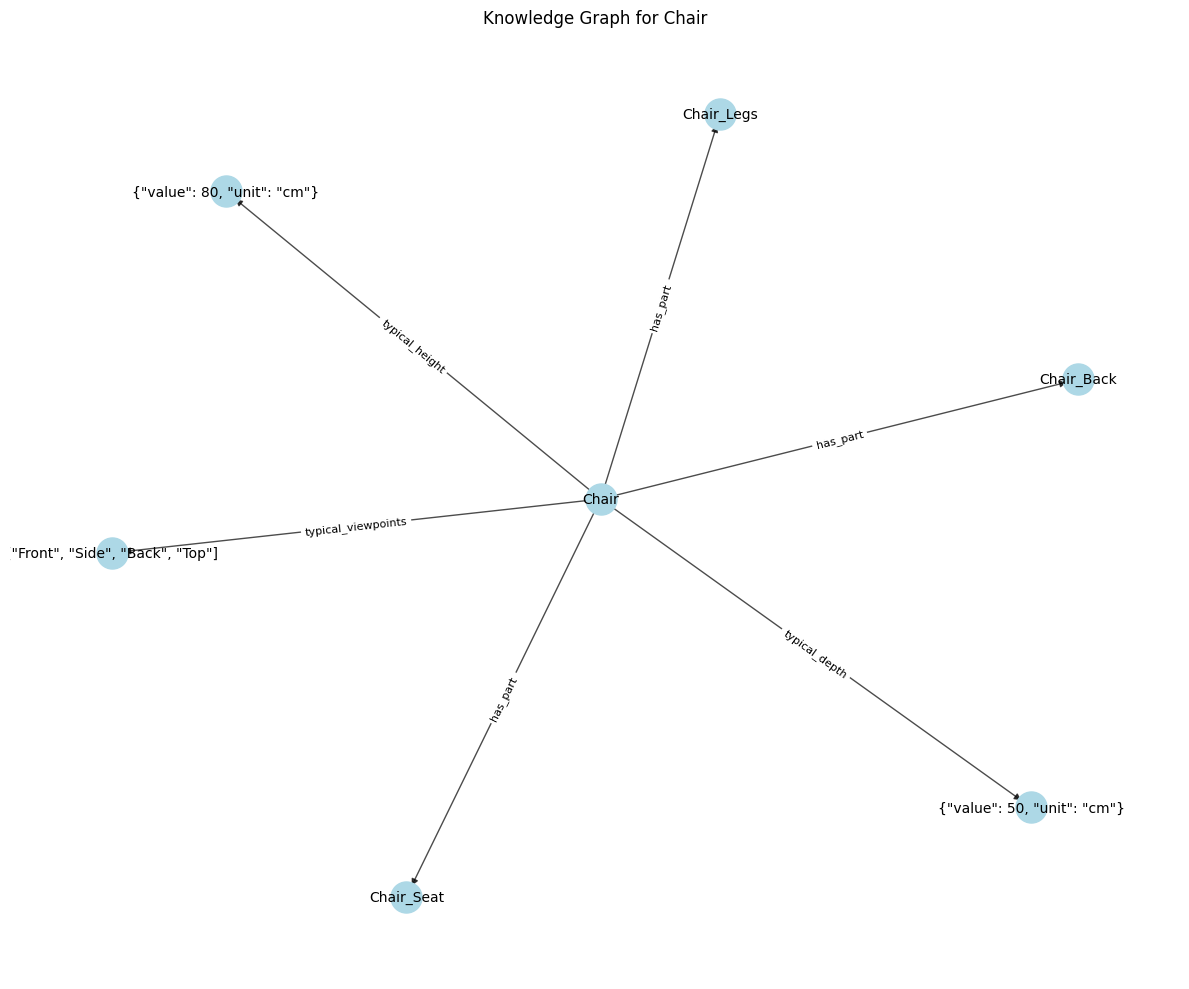

In [4]:
def visualize_knowledge_graph_for_object(kg, object_type):
    # Create a subgraph for the specific object type
    subgraph_nodes = [object_type]
    for node in kg.successors(object_type):
        subgraph_nodes.append(node)
        # Add parts' visibility information
        if kg.get_edge_data(object_type, node, default={}).get('relation') == 'has_part':
            for vis_node in kg.successors(node):
                if 'visibility' in kg.get_edge_data(node, vis_node, default={}):
                    subgraph_nodes.append(vis_node)
    
    subgraph = kg.subgraph(subgraph_nodes)
    
    # Create positions for nodes
    pos = nx.spring_layout(subgraph, seed=42)
    
    plt.figure(figsize=(12, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, 
                          node_color='lightblue', 
                          node_size=500)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.7)
    
    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=10)
    
    # Draw edge labels
    edge_labels = {}
    for u, v, data in subgraph.edges(data=True):
        if 'relation' in data:
            if 'value' in data:
                edge_labels[(u, v)] = f"{data['relation']}: {data['value']}"
            else:
                edge_labels[(u, v)] = data['relation']
    
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Knowledge Graph for {object_type}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize knowledge graph for Chair
visualize_knowledge_graph_for_object(kg, "Chair")

## Define Symbolic Reasoning Rules

Now let's define some rules for reasoning about 3D objects from different viewpoints:


In [5]:
# Define rules for inferring 3D properties from 2D views
class SymbolicReasoner:
    def __init__(self, knowledge_graph):
        self.kg = knowledge_graph
    
    def get_object_parts(self, object_type):
        """Get all parts of an object type."""
        parts = []
        for successor in self.kg.successors(object_type):
            edge_data = self.kg.get_edge_data(object_type, successor)
            if edge_data.get('relation') == 'has_part':
                part_name = successor.split('_')[1]  # Extract part name from node
                parts.append(part_name)
        return parts
    
    def get_typical_dimensions(self, object_type):
        """Get typical dimensions of an object type."""
        dimensions = {}
        for successor in self.kg.successors(object_type):
            edge_data = self.kg.get_edge_data(object_type, successor)
            if edge_data.get('relation') in ['typical_height', 'typical_width', 'typical_depth']:
                try:
                    dimensions[edge_data['relation']] = json.loads(successor)
                except:
                    dimensions[edge_data['relation']] = successor
        return dimensions
    
    def get_part_visibility(self, object_type, part, viewpoint):
        """Get visibility of a part from a specific viewpoint."""
        part_node = f"{object_type}_{part}"
        
        # Check if the part node exists
        if part_node not in self.kg:
            return None
        
        # Check visibility information
        for successor in self.kg.successors(part_node):
            if successor == viewpoint:
                edge_data = self.kg.get_edge_data(part_node, successor)
                if edge_data.get('relation') == 'visibility':
                    return edge_data.get('value', 0.0)
        
        return 0.0  # Default visibility if not specified
    
    def infer_occluded_parts(self, object_type, viewpoint, visibility_threshold=0.5):
        """Infer which parts are occluded from a specific viewpoint."""
        parts = self.get_object_parts(object_type)
        occluded_parts = []
        
        for part in parts:
            visibility = self.get_part_visibility(object_type, part, viewpoint)
            if visibility is not None and visibility < visibility_threshold:
                occluded_parts.append(part)
        
        return occluded_parts
    
    def infer_visible_parts(self, object_type, viewpoint, visibility_threshold=0.5):
        """Infer which parts are visible from a specific viewpoint."""
        parts = self.get_object_parts(object_type)
        visible_parts = []
        
        for part in parts:
            visibility = self.get_part_visibility(object_type, part, viewpoint)
            if visibility is not None and visibility >= visibility_threshold:
                visible_parts.append(part)
        
        return visible_parts
    
    def predict_other_viewpoint(self, object_type, current_viewpoint, target_viewpoint):
        """Predict visible parts in another viewpoint based on current viewpoint."""
        currently_visible = self.infer_visible_parts(object_type, current_viewpoint)
        target_visible = self.infer_visible_parts(object_type, target_viewpoint)
        
        newly_visible = [part for part in target_visible if part not in currently_visible]
        newly_occluded = [part for part in currently_visible if part not in target_visible]
        
        return {
            "newly_visible": newly_visible,
            "newly_occluded": newly_occluded
        }
    
    def estimate_3d_structure(self, object_type):
        """Estimate 3D structure based on typical dimensions and parts."""
        dimensions = self.get_typical_dimensions(object_type)
        parts = self.get_object_parts(object_type)
        
        # Create a simple 3D structure description
        structure = {
            "type": object_type,
            "dimensions": dimensions,
            "parts": parts,
            "spatial_arrangement": self._infer_spatial_arrangement(object_type, parts)
        }
        
        return structure
    
    def _infer_spatial_arrangement(self, object_type, parts):
        """Infer spatial arrangement of parts (simplified implementation)."""
        arrangement = {}
        
        if object_type == "Chair":
            arrangement = {
                "Back": {"position": "rear_top", "relative_size": "large"},
                "Seat": {"position": "middle", "relative_size": "large"},
                "Legs": {"position": "bottom", "relative_size": "small"}
            }
        elif object_type == "Table":
            arrangement = {
                "Surface": {"position": "top", "relative_size": "large"},
                "Legs": {"position": "bottom", "relative_size": "medium"}
            }
        elif object_type == "Cup":
            arrangement = {
                "Body": {"position": "center", "relative_size": "large"},
                "Handle": {"position": "side", "relative_size": "small"},
                "Bottom": {"position": "bottom", "relative_size": "medium"}
            }
        # Add more object types as needed
        
        return arrangement

# Create a symbolic reasoner
reasoner = SymbolicReasoner(kg)

## Test Symbolic Reasoning

Let's test our symbolic reasoning component:

In [6]:
# Test object part visibility inference
object_type = "Chair"
viewpoint = "Front"

print(f"Parts of a {object_type}:")
parts = reasoner.get_object_parts(object_type)
print(parts)
print()

print(f"Visible parts of a {object_type} from {viewpoint}:")
visible_parts = reasoner.infer_visible_parts(object_type, viewpoint)
print(visible_parts)
print()

print(f"Occluded parts of a {object_type} from {viewpoint}:")
occluded_parts = reasoner.infer_occluded_parts(object_type, viewpoint)
print(occluded_parts)
print()


# Test viewpoint change prediction
current_viewpoint = "Front"
target_viewpoint = "Side"
print(f"Predicting changes when moving from {current_viewpoint} to {target_viewpoint} viewpoint for {object_type}:")
viewpoint_changes = reasoner.predict_other_viewpoint(object_type, current_viewpoint, target_viewpoint)
print(f"Newly visible parts: {viewpoint_changes['newly_visible']}")
print(f"Newly occluded parts: {viewpoint_changes['newly_occluded']}")
print()

# Test 3D structure estimation
print(f"Estimated 3D structure of a {object_type}:")
structure = reasoner.estimate_3d_structure(object_type)
print(json.dumps(structure, indent=2))

Parts of a Chair:
['Back', 'Seat', 'Legs']

Visible parts of a Chair from Front:
['Back', 'Seat', 'Legs']

Occluded parts of a Chair from Front:
[]

Predicting changes when moving from Front to Side viewpoint for Chair:
Newly visible parts: []
Newly occluded parts: []

Estimated 3D structure of a Chair:
{
  "type": "Chair",
  "dimensions": {
    "typical_height": {
      "value": 80,
      "unit": "cm"
    },
    "typical_depth": {
      "value": 50,
      "unit": "cm"
    }
  },
  "parts": [
    "Back",
    "Seat",
    "Legs"
  ],
  "spatial_arrangement": {
    "Back": {
      "position": "rear_top",
      "relative_size": "large"
    },
    "Seat": {
      "position": "middle",
      "relative_size": "large"
    },
    "Legs": {
      "position": "bottom",
      "relative_size": "small"
    }
  }
}


## Visualize Part Visibility Across Viewpoints

Let's visualize the visibility of different parts across viewpoints:

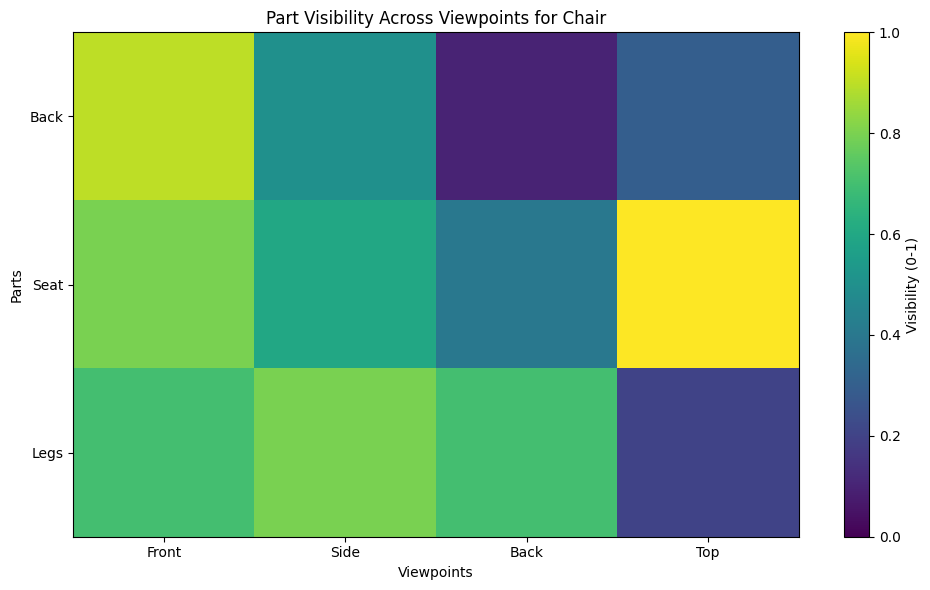

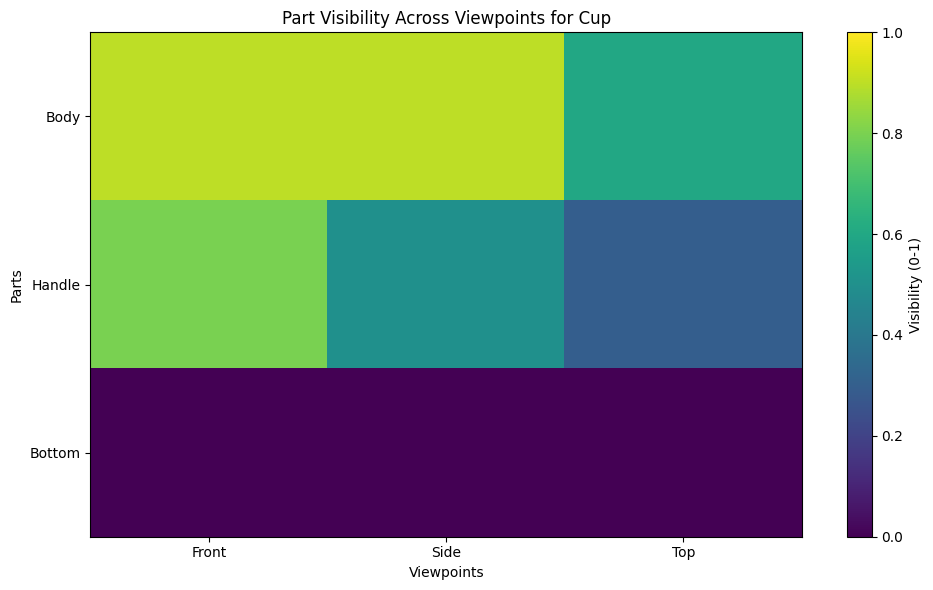

In [7]:
def visualize_part_visibility(reasoner, object_type, viewpoints=None):
    """Visualize part visibility across different viewpoints."""
    if viewpoints is None:
        # Get all viewpoints from the properties
        viewpoints = []
        for successor in reasoner.kg.successors(object_type):
            edge_data = reasoner.kg.get_edge_data(object_type, successor)
            if edge_data.get('relation') == 'typical_viewpoints':
                try:
                    viewpoints = json.loads(successor)
                except:
                    if isinstance(successor, str) and successor.startswith('['):
                        viewpoints = json.loads(successor)
                    else:
                        viewpoints = [successor]
    
    parts = reasoner.get_object_parts(object_type)
    
    # Create a matrix of visibility values
    visibility_matrix = np.zeros((len(parts), len(viewpoints)))
    
    for i, part in enumerate(parts):
        for j, viewpoint in enumerate(viewpoints):
            visibility = reasoner.get_part_visibility(object_type, part, viewpoint)
            if visibility is not None:
                visibility_matrix[i, j] = visibility
    
    # Create a heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(visibility_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    
    # Add labels
    plt.yticks(range(len(parts)), parts)
    plt.xticks(range(len(viewpoints)), viewpoints)
    plt.colorbar(label='Visibility (0-1)')
    
    plt.title(f'Part Visibility Across Viewpoints for {object_type}')
    plt.ylabel('Parts')
    plt.xlabel('Viewpoints')
    
    plt.tight_layout()
    plt.show()

# Visualize part visibility for Chair
visualize_part_visibility(reasoner, "Chair")

# Visualize part visibility for Cup
visualize_part_visibility(reasoner, "Cup")

## Create Simple 3D Visualization

Let's create a simple 3D visualization based on our symbolic representation:


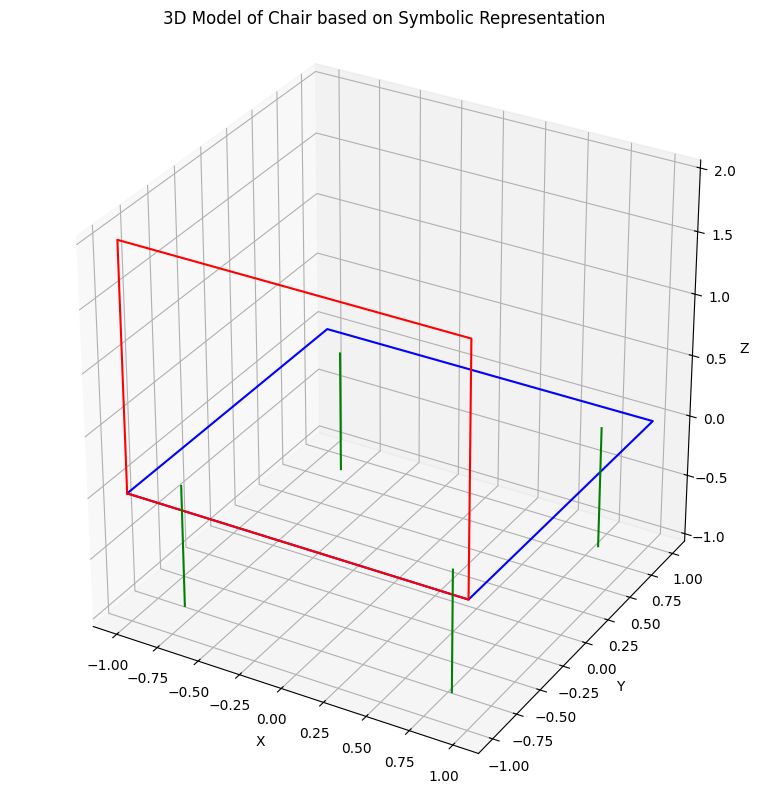

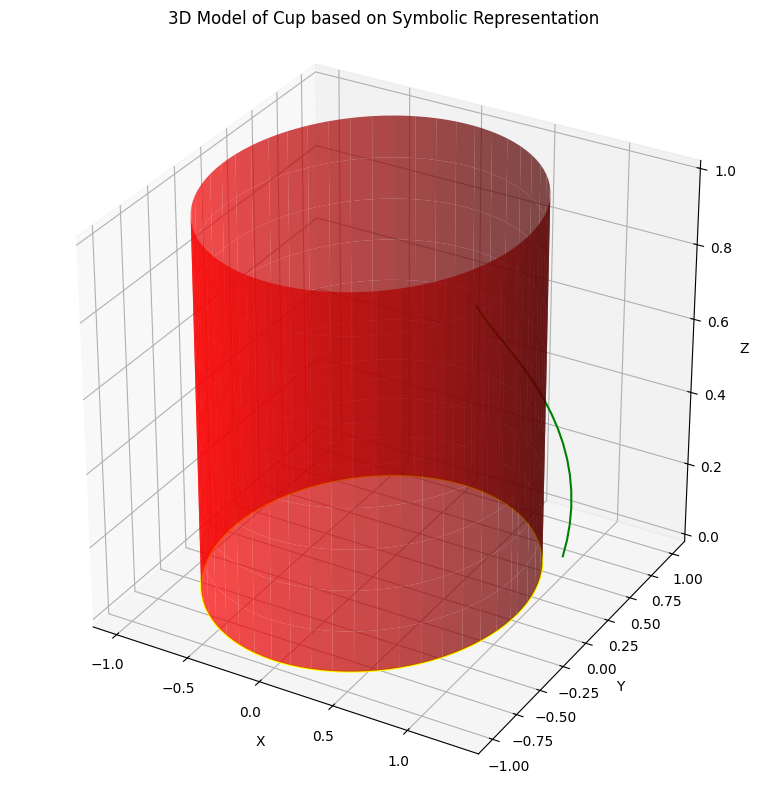

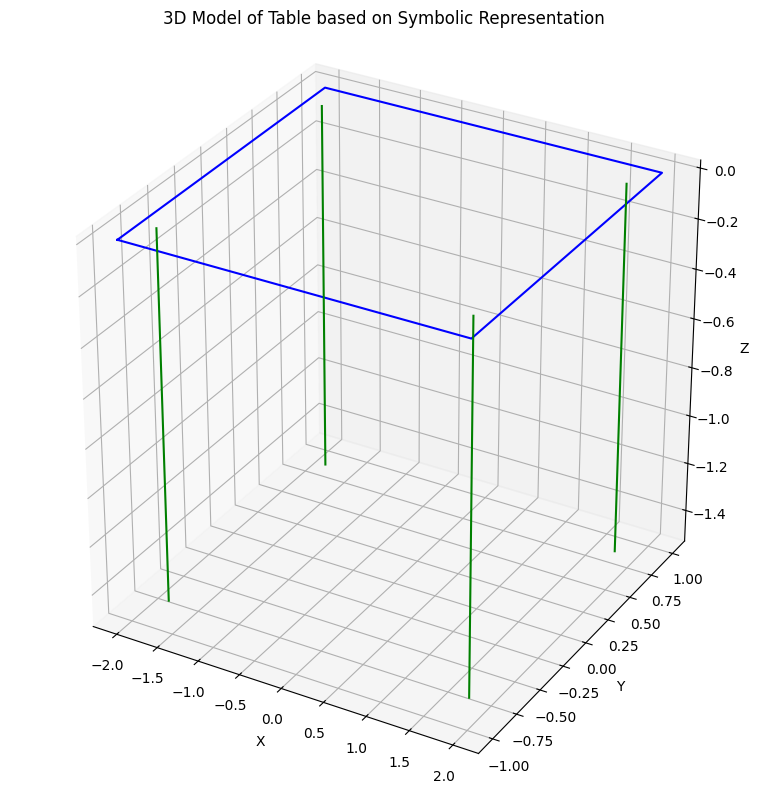

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as colors

def create_simple_3d_model(reasoner, object_type):
    """Create a simple 3D visualization of an object."""
    structure = reasoner.estimate_3d_structure(object_type)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for different parts
    color_map = {
        "Back": "red",
        "Seat": "blue",
        "Legs": "green",
        "Surface": "blue",
        "Body": "red",
        "Handle": "green",
        "Bottom": "yellow",
        "Cover": "blue",
        "Pages": "white",
        "Spine": "red",
        "Screen": "cyan", 
        "Keyboard": "black",
    }
    
    # Simple 3D model based on object type
    if object_type == "Chair":
        # Create a simple chair model
        # Seat
        x = np.array([-1, 1, 1, -1, -1])
        y = np.array([-1, -1, 1, 1, -1])
        z = np.array([0, 0, 0, 0, 0])
        ax.plot3D(x, y, z, color=color_map["Seat"])
        
        # Back
        x = np.array([-1, 1, 1, -1, -1])
        y = np.array([-1, -1, -1, -1, -1])
        z = np.array([0, 0, 2, 2, 0])
        ax.plot3D(x, y, z, color=color_map["Back"])
        
        # Legs (simplified as 4 lines)
        leg_positions = [(-0.8, -0.8), (0.8, -0.8), (0.8, 0.8), (-0.8, 0.8)]
        for pos in leg_positions:
            x = [pos[0], pos[0]]
            y = [pos[1], pos[1]]
            z = [0, -1]
            ax.plot3D(x, y, z, color=color_map["Legs"])
        
    elif object_type == "Cup":
        # Create a simple cup model
        # Cup body (cylinder)
        theta = np.linspace(0, 2*np.pi, 100)
        height = np.linspace(0, 1, 10)
        theta_grid, z_grid = np.meshgrid(theta, height)
        x_grid = np.cos(theta_grid)
        y_grid = np.sin(theta_grid)
        
        ax.plot_surface(x_grid, y_grid, z_grid, color=color_map["Body"], alpha=0.7)
        
        # Handle
        theta = np.linspace(0, np.pi, 20)
        x = 1 + 0.3 * np.cos(theta)
        y = 0.3 * np.sin(theta)
        z = np.linspace(0.2, 0.8, 20)
        ax.plot3D(x, y, z, color=color_map["Handle"])
        
        # Bottom (circle)
        theta = np.linspace(0, 2*np.pi, 100)
        x = np.cos(theta)
        y = np.sin(theta)
        z = np.zeros_like(theta)
        ax.plot3D(x, y, z, color=color_map["Bottom"])
    
    elif object_type == "Table":
        # Table surface
        x = np.array([-2, 2, 2, -2, -2])
        y = np.array([-1, -1, 1, 1, -1])
        z = np.array([0, 0, 0, 0, 0])
        ax.plot3D(x, y, z, color=color_map["Surface"])
        
        # Table legs
        leg_positions = [(-1.8, -0.8), (1.8, -0.8), (1.8, 0.8), (-1.8, 0.8)]
        for pos in leg_positions:
            x = [pos[0], pos[0]]
            y = [pos[1], pos[1]]
            z = [0, -1.5]
            ax.plot3D(x, y, z, color=color_map["Legs"])
    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Set title
    ax.set_title(f'3D Model of {object_type} based on Symbolic Representation')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    plt.tight_layout()
    plt.show()

# Create 3D visualizations
create_simple_3d_model(reasoner, "Chair")
create_simple_3d_model(reasoner, "Cup")
create_simple_3d_model(reasoner, "Table")

## Viewpoint-Based Rendering

Let's implement a simple function to render the object from different viewpoints:


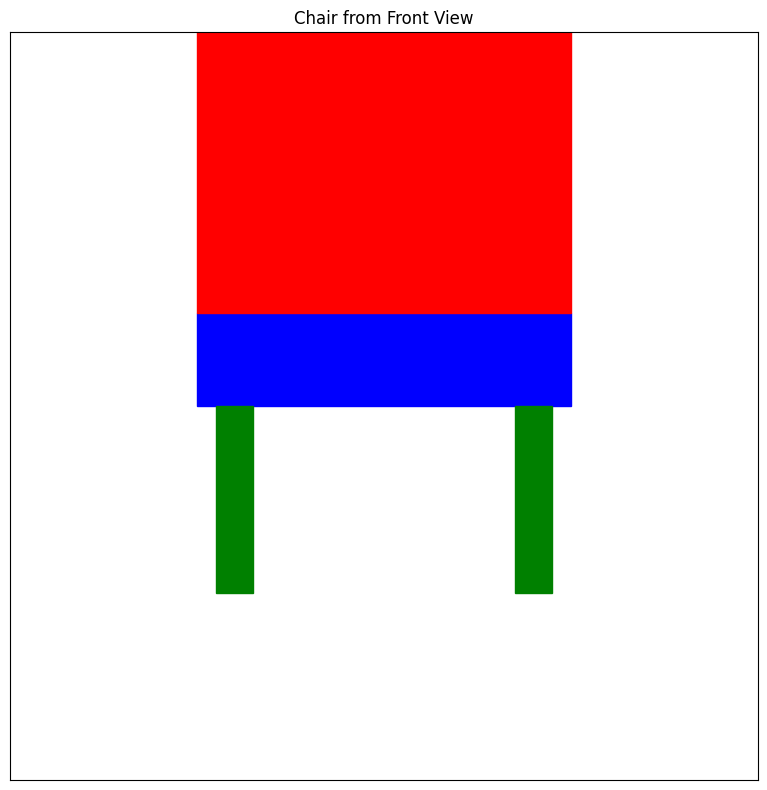

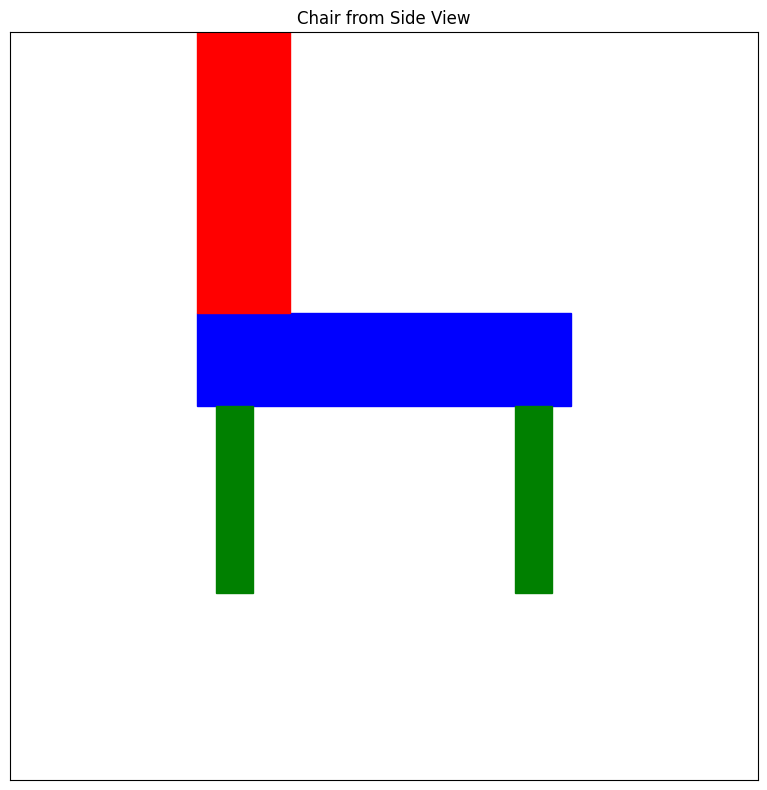

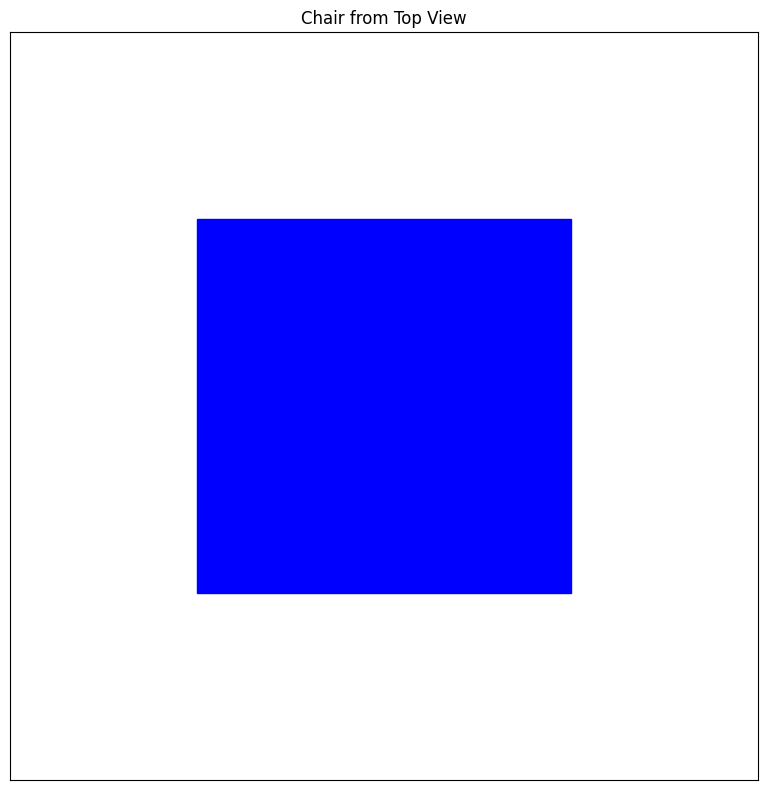

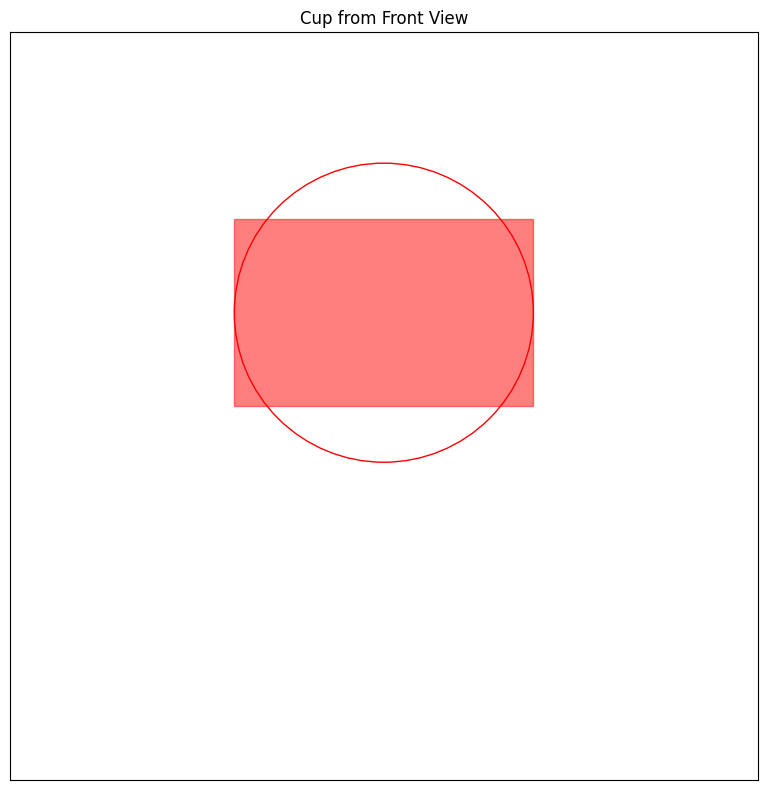

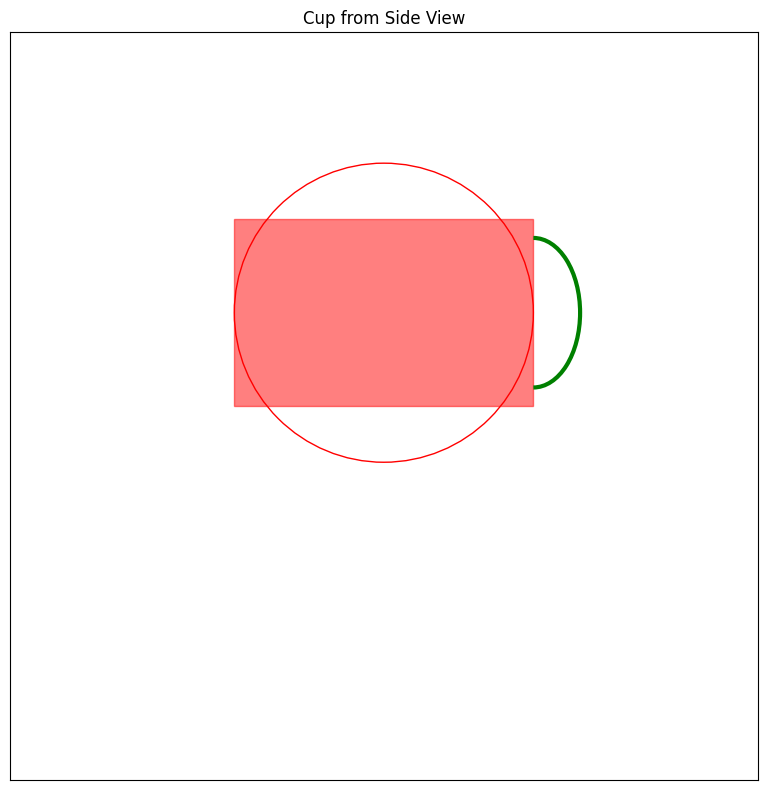

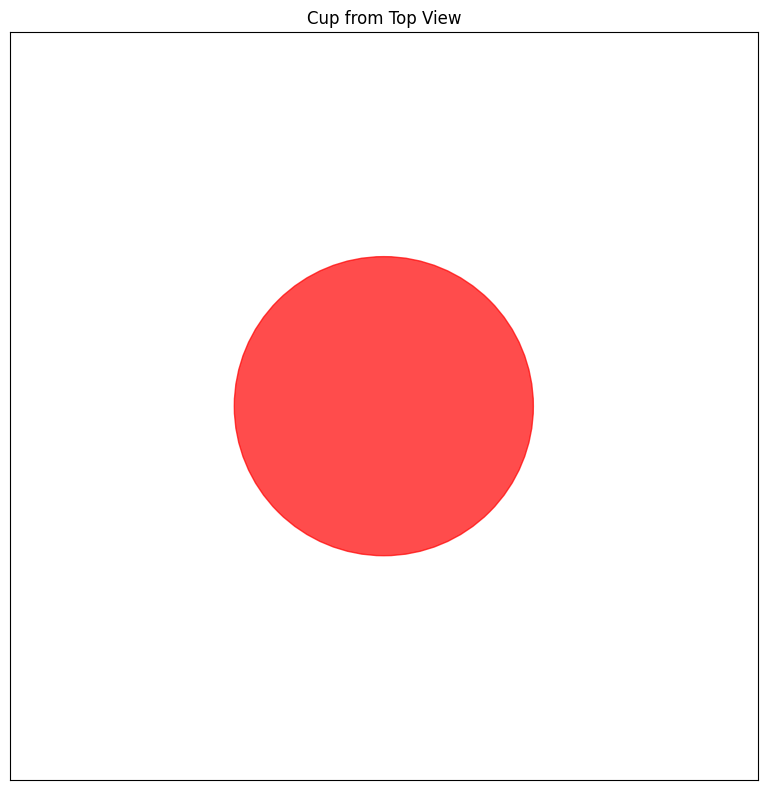

In [10]:
import matplotlib.patches as patches

def render_from_viewpoint(reasoner, object_type, viewpoint):
    """Render the object from a specific viewpoint."""
    # Get visible parts from this viewpoint
    visible_parts = reasoner.infer_visible_parts(object_type, viewpoint)
    
    # Create a figure
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    
    # Define colors for different parts
    color_map = {
        "Back": "red",
        "Seat": "blue",
        "Legs": "green",
        "Surface": "blue",
        "Body": "red",
        "Handle": "green",
        "Bottom": "yellow"
    }
    
    # Simplified 2D rendering based on viewpoint
    if object_type == "Chair":
        if viewpoint == "Front":
            # Draw seat
            if "Seat" in visible_parts:
                rect = plt.Rectangle((-1, 0), 2, 0.5, color=color_map["Seat"])
                ax.add_patch(rect)
            
            # Draw back
            if "Back" in visible_parts:
                rect = plt.Rectangle((-1, 0.5), 2, 1.5, color=color_map["Back"])
                ax.add_patch(rect)
            
            # Draw legs
            if "Legs" in visible_parts:
                # Left legs
                rect = plt.Rectangle((-0.9, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
                # Right legs
                rect = plt.Rectangle((0.7, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
        
        elif viewpoint == "Side":
            # Draw seat
            if "Seat" in visible_parts:
                rect = plt.Rectangle((-1, 0), 2, 0.5, color=color_map["Seat"])
                ax.add_patch(rect)
            
            # Draw back (from side view)
            if "Back" in visible_parts:
                rect = plt.Rectangle((-1, 0.5), 0.5, 1.5, color=color_map["Back"])
                ax.add_patch(rect)
            
            # Draw legs
            if "Legs" in visible_parts:
                # Front leg
                rect = plt.Rectangle((0.7, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
                # Back leg
                rect = plt.Rectangle((-0.9, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
        
        elif viewpoint == "Top":
            # Draw seat (top view)
            if "Seat" in visible_parts:
                rect = plt.Rectangle((-1, -1), 2, 2, color=color_map["Seat"])
                ax.add_patch(rect)
            
            # Draw back edge (top view)
            if "Back" in visible_parts:
                rect = plt.Rectangle((-1, -1), 2, 0.3, color=color_map["Back"])
                ax.add_patch(rect)
    
    elif object_type == "Cup":
        if viewpoint == "Front" or viewpoint == "Side":
            # Draw cup body
            if "Body" in visible_parts:
                # Cup outline
                circle = plt.Circle((0, 0.5), 0.8, fill=False, color=color_map["Body"])
                ax.add_patch(circle)
                # Cup body
                rect = plt.Rectangle((-0.8, 0), 1.6, 1, color=color_map["Body"], alpha=0.5)
                ax.add_patch(rect)
            
            # Draw handle
            if "Handle" in visible_parts and viewpoint == "Side":
                arc = patches.Arc((0.8, 0.5), 0.5, 0.8, theta1=270, theta2=90, color=color_map["Handle"], linewidth=3)
                ax.add_patch(arc)
            
            # Draw bottom (only visible in wireframe)
            if "Bottom" in visible_parts:
                line = plt.Line2D([-0.8, 0.8], [0, 0], color=color_map["Bottom"])
                ax.add_line(line)
        
        elif viewpoint == "Top":
            # Draw top circle
            if "Body" in visible_parts:
                circle = plt.Circle((0, 0), 0.8, color=color_map["Body"], alpha=0.7)
                ax.add_patch(circle)
            
            # Draw handle view from top
            if "Handle" in visible_parts:
                rect = plt.Rectangle((0.8, -0.2), 0.3, 0.4, color=color_map["Handle"])
                ax.add_patch(rect)
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Set limits
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    # Set title
    ax.set_title(f'{object_type} from {viewpoint} View')
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

# Render chair from different viewpoints
render_from_viewpoint(reasoner, "Chair", "Front")
render_from_viewpoint(reasoner, "Chair", "Side")
render_from_viewpoint(reasoner, "Chair", "Top")

# Render cup from different viewpoints
render_from_viewpoint(reasoner, "Cup", "Front")
render_from_viewpoint(reasoner, "Cup", "Side")
render_from_viewpoint(reasoner, "Cup", "Top")

## Integrating Rules for Single-to-Multiview Inference

Now let's create functions that would infer multiview information from a single view:


Inferring other viewpoints for Chair based on Front view:
For Side view:
  Newly visible parts: []
  Newly occluded parts: []

For Back view:
  Newly visible parts: []
  Newly occluded parts: ['Back', 'Seat']

For Top view:
  Newly visible parts: []
  Newly occluded parts: ['Back', 'Legs']



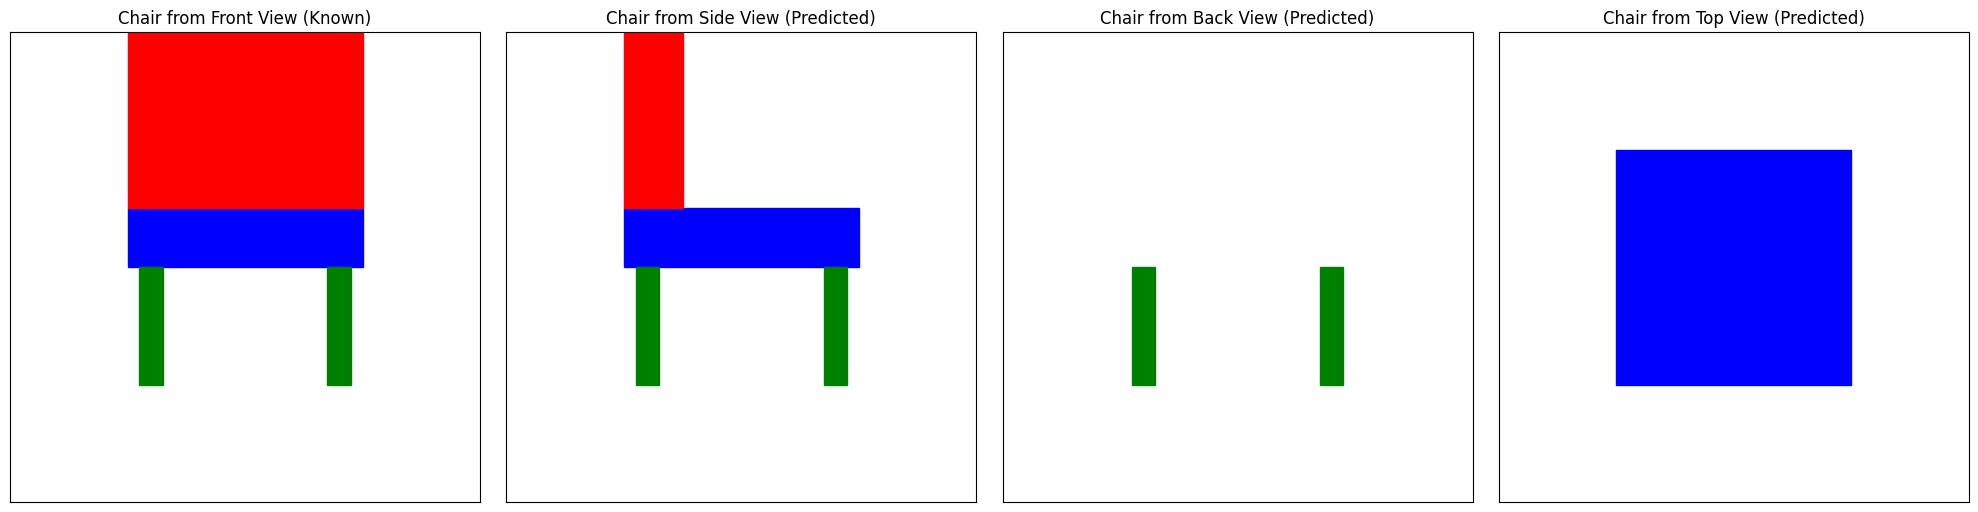

In [11]:
def infer_multiview_from_single(reasoner, object_type, known_viewpoint, target_viewpoints=None):
    """Infer multiple viewpoints from a single known viewpoint."""
    if target_viewpoints is None:
        # Get all viewpoints from the properties
        for successor in reasoner.kg.successors(object_type):
            edge_data = reasoner.kg.get_edge_data(object_type, successor)
            if edge_data.get('relation') == 'typical_viewpoints':
                try:
                    target_viewpoints = json.loads(successor)
                except:
                    if isinstance(successor, str) and successor.startswith('['):
                        target_viewpoints = json.loads(successor)
                    else:
                        target_viewpoints = [successor]
    
    # Remove the known viewpoint from targets
    if known_viewpoint in target_viewpoints:
        target_viewpoints = [vp for vp in target_viewpoints if vp != known_viewpoint]
    
    results = {}
    for target_vp in target_viewpoints:
        results[target_vp] = reasoner.predict_other_viewpoint(object_type, known_viewpoint, target_vp)
    
    return results

# Test multiview inference
object_type = "Chair"
known_viewpoint = "Front"
target_viewpoints = ["Side", "Back", "Top"]

print(f"Inferring other viewpoints for {object_type} based on {known_viewpoint} view:")
multiview_results = infer_multiview_from_single(reasoner, object_type, known_viewpoint, target_viewpoints)

for vp, result in multiview_results.items():
    print(f"For {vp} view:")
    print(f"  Newly visible parts: {result['newly_visible']}")
    print(f"  Newly occluded parts: {result['newly_occluded']}")
    print()

# Visualize multiview inference results
fig, axes = plt.subplots(1, len(target_viewpoints) + 1, figsize=(5 * (len(target_viewpoints) + 1), 5))

# First, show the known viewpoint
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title(f'{object_type} from {known_viewpoint} View (Known)')

# Simplified drawing for the known viewpoint
visible_parts = reasoner.infer_visible_parts(object_type, known_viewpoint)
color_map = {"Back": "red", "Seat": "blue", "Legs": "green"}

# Draw the known view (simplified for Chair front view)
if object_type == "Chair" and known_viewpoint == "Front":
    # Draw seat
    if "Seat" in visible_parts:
        rect = plt.Rectangle((-1, 0), 2, 0.5, color=color_map["Seat"])
        ax.add_patch(rect)
    
    # Draw back
    if "Back" in visible_parts:
        rect = plt.Rectangle((-1, 0.5), 2, 1.5, color=color_map["Back"])
        ax.add_patch(rect)
    
    # Draw legs
    if "Legs" in visible_parts:
        # Left legs
        rect = plt.Rectangle((-0.9, -1), 0.2, 1, color=color_map["Legs"])
        ax.add_patch(rect)
        # Right legs
        rect = plt.Rectangle((0.7, -1), 0.2, 1, color=color_map["Legs"])
        ax.add_patch(rect)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Then show predicted views
for i, vp in enumerate(target_viewpoints):
    ax = axes[i + 1]
    ax.set_aspect('equal')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f'{object_type} from {vp} View (Predicted)')
    
    # Get parts visible from this viewpoint
    visible_parts = reasoner.infer_visible_parts(object_type, vp)
    
    # Draw simplified view based on the object and viewpoint
    if object_type == "Chair":
        if vp == "Side":
            # Draw seat
            if "Seat" in visible_parts:
                rect = plt.Rectangle((-1, 0), 2, 0.5, color=color_map["Seat"])
                ax.add_patch(rect)
            
            # Draw back (from side view)
            if "Back" in visible_parts:
                rect = plt.Rectangle((-1, 0.5), 0.5, 1.5, color=color_map["Back"])
                ax.add_patch(rect)
            
            # Draw legs
            if "Legs" in visible_parts:
                # Front leg
                rect = plt.Rectangle((0.7, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
                # Back leg
                rect = plt.Rectangle((-0.9, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
        
        elif vp == "Back":
            # Draw seat
            if "Seat" in visible_parts:
                rect = plt.Rectangle((-1, 0), 2, 0.5, color=color_map["Seat"])
                ax.add_patch(rect)
            
            # Draw back (from back view - just a thin line)
            if "Back" in visible_parts:
                rect = plt.Rectangle((-1, 0.5), 2, 0.1, color=color_map["Back"])
                ax.add_patch(rect)
            
            # Draw legs
            if "Legs" in visible_parts:
                # Left legs
                rect = plt.Rectangle((-0.9, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
                # Right legs
                rect = plt.Rectangle((0.7, -1), 0.2, 1, color=color_map["Legs"])
                ax.add_patch(rect)
        
        elif vp == "Top":
            # Draw seat (top view)
            if "Seat" in visible_parts:
                rect = plt.Rectangle((-1, -1), 2, 2, color=color_map["Seat"])
                ax.add_patch(rect)
            
            # Draw back edge (top view)
            if "Back" in visible_parts:
                rect = plt.Rectangle((-1, -1), 2, 0.3, color=color_map["Back"])
                ax.add_patch(rect)
            
            # Legs usually not visible from top
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## Conclusion

In this tutorial, we've implemented a symbolic reasoning component for spatial relationships and 3D understanding. Key features include:

1. A knowledge graph representation of 3D objects and their properties
2. Rules for reasoning about part visibility from different viewpoints
3. Inference of occluded and visible parts
4. Prediction of appearance changes when viewing from different angles
5. Simple 3D model creation based on symbolic representation
6. Viewpoint-based rendering
7. Multiview inference from a single viewpoint

This symbolic component can now be integrated with the LLM and vision components from the previous tutorials to create a complete neurosymbolic system for single-to-multiview 3D representation.